<a href="https://colab.research.google.com/github/aminaalavi/AI-Projects/blob/main/AlphaLens/AlphaLens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 AlphaLens Earnings Pack

Automated multi-agent system for generating **portfolio-ready earnings analysis**.  
AlphaLens transforms scattered financial data — SEC filings, consensus estimates, and transcripts — into a polished, markdown-based *Earnings Pack* ready for PM briefings or investment committee decks.

---

## 🎯 What It Does

AlphaLens automates a complete **sell-side research workflow**:

1. **Research Agent** — Combines SEC / IR filings and Street consensus → *Pre-Call Brief*  
2. **Analyst Agent** — Builds post-call deltas, scenarios, and risks → *Post-Call Analysis*  
3. **Chart Maker Agent** — Pulls last 90-day price history via Yahoo Finance → *Price Trend Chart*  
4. **Packaging Agent** — Merges everything into a professional Markdown report → *Earnings Pack (Markdown + Inline Chart)*  


In [ ]:
# -*- coding: utf-8 -*-
"""Earnings-Pack Copilot for Equity Research.ipynb"""

# ============================================================
# 1. SETUP
# ============================================================

import sys, os
from google.colab import userdata
from google.colab import drive
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/LLM/Ng/EarningsPack'
os.chdir(project_path)
sys.path.append(project_path)

print("Current directory:", os.getcwd())
!ls

# 🔧 Required libraries
!pip install aisuite[openai] -q
!pip install tavily-python -q
!pip install yfinance -q
!pip install matplotlib -q
!pip install pandas -q

Mounted at /content/drive
Current directory: /content/drive/My Drive/LLM/Ng/EarningsPack
AAPL_price_chart.png
AlphaLens.ipynb
BAC_Earnings_Pack_2025-10-14_00-19-23.md
BAC_Earnings_Pack_2025-10-14_00-21-11.md
BAC_price_chart.png
NVDA_earnings_pack_2025-10-13_20-31-43.md
NVDA_earnings_pack_2025-10-13_20-39-39.md
NVDA_Earnings_Pack_2025-10-13_20-53-36.md
NVDA_Earnings_Pack_2025-10-13_20-59-02.md
NVDA_Earnings_Pack_2025-10-13_23-12-00.md
NVDA_price_chart.png
TSLA_Earnings_Pack_2025-10-13_21-03-43.md
TSLA_Earnings_Pack_2025-10-13_23-13-58.md
TSLA_Earnings_Pack_2025-10-13_23-16-41.md
TSLA_price_chart.png
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.44.0 requires httpx<1.0.0,>=0.28.1, but you have

In [ ]:


# ============================================================
# 2. LIBRARIES & HTML LOGGING
# ============================================================

import base64, json
from html import escape
from datetime import datetime
from typing import Any
import pandas as pd
from IPython.display import display, HTML, Markdown
import matplotlib.pyplot as plt
import yfinance as yf
import aisuite
from tavily import TavilyClient
from dotenv import load_dotenv

def log_agent_title_html(title, icon="🧠"):
    display(HTML(f"""
    <div style="padding:1em;margin:1em 0;background-color:#f0f4f8;border-left:6px solid #1976D2;">
    <h2 style="margin:0;color:#0D47A1;">{icon} {escape(title)}</h2></div>"""))

def log_tool_call_html(tool_name, arguments):
    display(HTML(f"""
    <div style="border-left:4px solid #1976D2;padding:.8em;margin:1em 0;
                background-color:#e3f2fd;color:#0D47A1;">
      <strong>📞 Tool Call:</strong> {escape(tool_name)}
      <pre style="background:#e8f0fe;padding:6px;border-radius:4px;">{escape(str(arguments))}</pre>
    </div>"""))

def log_tool_result_html(result):
    display(HTML(f"""
    <div style="border-left:4px solid #558B2F;padding:.8em;margin:1em 0;
                background-color:#f1f8e9;color:#33691E;">
      <strong>✅ Tool Result:</strong>
      <pre style="white-space:pre-wrap;font-size:13px;color:#2E7D32;">{escape(str(result))}</pre>
    </div>"""))

def log_final_summary_html(content):
    display(HTML(f"""
      <div style="border-left:4px solid #2E7D32;padding:1em;margin:1em 0;
                  background-color:#e8f5e9;color:#1B5E20;">
        <strong>✅ Final Summary:</strong>
        <pre style="white-space:pre-wrap;font-size:13px;">{escape(content.strip())}</pre>
      </div>"""))

# ============================================================
# 3. ENVIRONMENT & CLIENT
# ============================================================

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
load_dotenv()
client = aisuite.Client()

In [ ]:


# ============================================================
# 4. TOOLS
# ============================================================

import os
from tavily import TavilyClient

def sec_filings_search_tool(query: str, max_results: int = 5, include_images: bool = False):
    """
    Searches for company filings, transcripts, and investor-relations updates using Tavily.

    Args:
        query (str): Company name or ticker plus context (e.g., 'AAPL 10-Q earnings transcript').
        max_results (int): Number of search results.
        include_images (bool): Whether to include related visuals.

    Returns:
        list[dict]: List of {title, content, url}.
    """
    client_tv = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

    query = " ".join(query.split())

    try:
        response = client_tv.search(query=query, max_results=max_results, include_images=include_images)
        results = [
            {"title": r.get("title"), "content": r.get("content"), "url": r.get("url")}
            for r in response.get("results", [])
        ]
        return results
    except Exception as e:
        return [{"title": "⚠️ Error", "content": f"Tavily API call failed: {e}", "url": None}]


def consensus_api_tool(ticker: str):
    """
    Uses Tavily to retrieve analyst expectations, consensus numbers, or KPI trends.

    Args:
        ticker (str): Company ticker symbol.

    Returns:
        list[dict]: Snippets summarizing analyst forecasts and expectations.
    """
    query = f"{ticker} earnings consensus analyst expectations"
    query = " ".join(query.split())

    return sec_filings_search_tool(query=query, max_results=5)



def price_history_tool(ticker: str, lookback_days: int = 90) -> pd.DataFrame:
    """
    Fetches historical price data via Yahoo Finance for visualization.

    Args:
        ticker (str): Stock ticker.
        lookback_days (int): How many days of history to fetch.

    Returns:
        pd.DataFrame: Historical OHLCV dataframe.
    """
    df = yf.download(ticker, period=f"{lookback_days}d", interval="1d")
    df.reset_index(inplace=True)
    return df


def get_available_tools():
    """Registers the tools available to all agents."""
    return [
        {"type":"function","function":{
            "name":"sec_filings_search_tool",
            "description":"Search SEC filings, transcripts, or IR data using Tavily.",
            "parameters":{"type":"object","properties":{"query":{"type":"string"},"max_results":{"type":"integer"}}, "required":["query"]}}},
        {"type":"function","function":{
            "name":"consensus_api_tool",
            "description":"Fetch consensus estimates or analyst expectations using Tavily.",
            "parameters":{"type":"object","properties":{"ticker":{"type":"string"}}, "required":["ticker"]}}},
        {"type":"function","function":{
            "name":"price_history_tool",
            "description":"Fetch stock price history from Yahoo Finance.",
            "parameters":{"type":"object","properties":{"ticker":{"type":"string"}}, "required":["ticker"]}}}
    ]

In [ ]:
#TEST
import os
from tavily import TavilyClient

def sec_filings_search_tool(query: str, max_results: int = 5, include_images: bool = False):
    """
    Searches for company filings, transcripts, and investor-relations updates using Tavily.

    Args:
        query (str): Company name or ticker plus context (e.g., 'AAPL 10-Q earnings transcript').
        max_results (int): Number of search results.
        include_images (bool): Whether to include related visuals.

    Returns:
        list[dict]: List of {title, content, url}.
    """
    client_tv = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

    # Sanitize query to avoid Tavily 422 errors
    query = " ".join(query.split())

    try:
        response = client_tv.search(query=query, max_results=max_results, include_images=include_images)
        results = [
            {"title": r.get("title"), "content": r.get("content"), "url": r.get("url")}
            for r in response.get("results", [])
        ]
        return results
    except Exception as e:
        return [{"title": "⚠️ Error", "content": f"Tavily API call failed: {e}", "url": None}]


def consensus_api_tool(ticker: str):
    """
    Uses Tavily to retrieve analyst expectations, consensus numbers, or KPI trends.

    Args:
        ticker (str): Company ticker symbol.

    Returns:
        list[dict]: Snippets summarizing analyst forecasts and expectations.
    """
    query = f"{ticker} earnings consensus analyst expectations"
    query = " ".join(query.split())

    return sec_filings_search_tool(query=query, max_results=5)


In [ ]:
#TEST
from datetime import datetime

def research_agent(ticker: str):
    """
    Builds the Pre-Call Brief by combining management guidance (SEC / IR)
    and Street expectations (consensus) using Tavily tools.

    Tools available:
    - sec_filings_search_tool: pulls recent filings, transcripts, and guidance.
    - consensus_api_tool: fetches consensus revenue / EPS / margin data.

    Args:
        ticker (str): Company ticker symbol (e.g., "NVDA").

    Returns:
        str: Structured Pre-Call Brief in Markdown format.
    """

    log_agent_title_html("Research Agent", "🧩")

    # Step 1️⃣ — Fetch SEC/transcript commentary
    log_tool_result_html(f"🔍 Searching SEC filings and transcripts for {ticker} ...")
    sec_query = f"{ticker} latest earnings call transcript management guidance 10-Q highlights"
    sec_results = sec_filings_search_tool(query=sec_query, max_results=3)
    log_tool_result_html("✅ SEC / IR insights retrieved.")

    # Step 2️⃣ — Fetch consensus estimates
    log_tool_result_html(f"📊 Fetching consensus expectations for {ticker} ...")
    consensus_results = consensus_api_tool(ticker)
    log_tool_result_html("✅ Consensus estimates retrieved.")

    # Step 3️⃣ — Build unified prompt
    prompt = f"""
You are a sell-side equity research associate preparing a **Pre-Call Brief**
for {ticker} ahead of its next earnings call.

You have two sources:
1. **Management commentary and guidance (from SEC / transcripts):**
{sec_results}

2. **Street consensus expectations (from analyst data):**
{consensus_results}

Your objectives:
- Summarize the company’s tone, guidance, and strategic priorities.
- Create a Markdown table titled “### Guidance vs Consensus Snapshot”
  with columns: Metric | Management Guidance | Street Consensus | Delta | Comment.
- Add 2–3 focus areas investors will watch this quarter.
- End with a short “Analyst Preview” paragraph on sentiment and expectations.
- Keep tone professional, concise, factual.

Today’s date: {datetime.now().strftime("%Y-%m-%d")}
"""

    response = client.chat.completions.create(
        model="openai:o4-mini",
        messages=[{"role": "user", "content": prompt}]
    )

    summary = response.choices[0].message.content.strip()
    log_final_summary_html(summary)
    return summary


In [ ]:
# Test the research agent independently
research_result = research_agent("BAC")

In [ ]:
def analyst_agent(ticker: str, research_summary: str):
    """
    Compares reported and expected results, builds scenario cases, and identifies risks.

    Tools available:
    - consensus_api_tool (to verify updated estimates)
    - price_history_tool (for price trend context, optional)

    Args:
        ticker (str): Company ticker symbol.
        research_summary (str): Text from research_agent.

    Returns:
        str: Markdown with Post-Call Deltas, scenarios, and Top 5 Key Risks.
    """

    log_agent_title_html("Analyst Agent", "📊")

    prompt = f"""
You are a senior equity analyst reviewing {ticker}’s quarterly results.

Input:
{research_summary}

Your tasks:
1. Identify positive/negative KPI surprises vs. consensus.
2. Generate a Markdown table titled “### Post-Call Deltas”.
3. Build 3 scenario cases (Bull, Base, Bear) with key KPI assumptions.
4. Add a clearly formatted “### Top 5 Key Risks” list (numbered 1–5).

Tone: analytical, data-driven, clear, no fluff.
"""

    response = client.chat.completions.create(
        model="openai:o4-mini",
        messages=[{"role": "user", "content": prompt}]
    )

    summary = response.choices[0].message.content.strip()
    log_final_summary_html(summary)
    return summary


In [ ]:
# Pass in the previous agent's output
analyst_result = analyst_agent(
    ticker="NVDA",
    research_summary=research_result
)

In [ ]:

def chart_maker_agent(ticker: str):
    """
    Creates a 90-day price trend visualization using price_history_tool.

    Args:
        ticker (str): Stock ticker symbol.

    Returns:
        str: Path to the saved PNG chart.
    """
    log_agent_title_html("Chart Maker Agent", "📈")

    df = price_history_tool(ticker)
    plt.figure(figsize=(8,4))
    plt.plot(df["Date"], df["Close"], linewidth=2)
    plt.title(f"{ticker} — 90-Day Price Trend")
    plt.xlabel("Date"); plt.ylabel("Price ($)")
    plt.grid(True)
    chart_path = f"{ticker}_price_chart.png"
    plt.tight_layout(); plt.savefig(chart_path); plt.close()

    log_tool_result_html(f"Chart saved: {chart_path}")
    return chart_path




def earnings_packaging_agent(
    ticker: str,
    pre_call: str,
    post_call: str,
    chart_path: str,
    output_path: str = None
) -> str:
    """
    Packages the earnings analysis into a professional, investor-grade Markdown report.
    Pulls all text dynamically from the Research and Analyst agents.

    Args:
        ticker (str): Stock ticker symbol.
        pre_call (str): Pre-call brief from research_agent.
        post_call (str): Post-call deltas & risks from analyst_agent.
        chart_path (str): Path to the price trend chart image.
        output_path (str): Custom path for saving the Markdown report (optional).

    Returns:
        str: Path to the generated Markdown file.
    """

    log_agent_title_html("Earnings Packaging Agent", "📦")

    # Step 1️⃣: File setup
    if not output_path:
        output_path = f"{ticker}_Earnings_Pack_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.md"

    # Step 2️⃣: Inline chart embedding for Colab / Markdown rendering
    import base64
    def encode_image_to_base64(path):
        with open(path, "rb") as f:
            return base64.b64encode(f.read()).decode("utf-8")

    b64_chart = encode_image_to_base64(chart_path)
    chart_md = f'<p align="center"><img src="data:image/png;base64,{b64_chart}" width="600"/></p>\n<p align="center"><em>Figure: {ticker} Price Trend (Last 90 Days)</em></p>'

    # Step 3️⃣: Beautify, structure, and clean the text for portfolio-manager readability
    refinement_prompt = f"""
You are a senior equity research editor.
Your task is to combine and polish two analyst texts into a professional Markdown report for a portfolio manager.

1. **Structure it cleanly** with headers and whitespace.
2. **Preserve numeric integrity** (no broken characters, keep 1.5%, $46.7bn, etc.).
3. **Ensure a clearly labeled “Top 5 Key Risks” section** with numbered list (1–5).
4. **Ensure clear scenario cases** (Bull / Base / Bear).
5. **Preserve all insights from the input exactly — do NOT invent or replace text.**
6. Maintain analyst tone (factual, concise, data-driven).

Inputs:
---
PRE-CALL BRIEF:
{pre_call}

---
POST-CALL DELTAS, RISKS, AND SCENARIOS:
{post_call}
"""

    beautified = client.chat.completions.create(
        model="openai:o4-mini",
        messages=[
            {"role": "system", "content": "You are an equity research editor polishing analyst notes into structured Markdown reports."},
            {"role": "user", "content": refinement_prompt}
        ]
    ).choices[0].message.content.strip()

    # Step 4️⃣: Build the final formatted Markdown layout dynamically
    markdown_content = f"""
# 📈 {ticker} — Quarterly Earnings Pack
*Generated automatically on {datetime.now().strftime('%B %d, %Y')}*

---

{beautified}

---

## 📊 Quick Chart
{chart_md}

---


*Prepared automatically by the AlphaLens Agents 🧠 — integrating SEC filings, transcripts, and market data.*
"""

    # Step 5️⃣: Save Markdown file
    with open(output_path, "w", encoding="utf-8") as f:
        f.write(markdown_content)

    log_final_summary_html(f"✅ Earnings Pack successfully written to `{output_path}`")
    return output_path

In [ ]:
chart_path = chart_maker_agent("BAC")

/tmp/ipython-input-735939408.py:63: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=f"{lookback_days}d", interval="1d")
[*********************100%***********************]  1 of 1 completed


In [ ]:
final_md_path = earnings_packaging_agent(
    ticker="BAC",
    pre_call=research_result,
    post_call=analyst_result,
    chart_path=chart_path
)


#Now run the full WF in one go below

In [ ]:
def run_earnings_pack_pipeline(ticker: str):
    """
    🚀 Full Earnings-Pack Orchestrator
    ----------------------------------
    Runs all agents in sequence for a single ticker:
    1️⃣ research_agent – builds the pre-call brief (guidance + consensus)
    2️⃣ analyst_agent – builds post-call deltas, scenarios, and risks
    3️⃣ chart_maker_agent – generates price trend visualization
    4️⃣ earnings_packaging_agent – merges everything into final Markdown report

    Args:
        ticker (str): Stock ticker symbol (e.g., "NVDA", "AAPL").

    Returns:
        str: Path to the generated Markdown report.
    """

    print(f"\n🎯 Running full earnings pack pipeline for {ticker}...\n")

    # Step 1️⃣ — Research (Pre-Call Brief)
    print("🧩 Step 1: Research Agent (Pre-Call Brief)")
    research_output = research_agent(ticker)
    print("✅ Pre-Call Brief completed.\n")

    # Step 2️⃣ — Analyst (Post-Call Review)
    print("📊 Step 2: Analyst Agent (Post-Call Deltas & Risks)")
    analyst_output = analyst_agent(ticker, research_output)
    print("✅ Post-Call Analysis completed.\n")

    # Step 3️⃣ — Chart Maker
    print("📈 Step 3: Chart Maker Agent (Price Trend Visualization)")
    chart_path = chart_maker_agent(ticker)
    print(f"✅ Chart created at {chart_path}\n")

    # Step 4️⃣ — Packaging
    print("📦 Step 4: Packaging Agent (Generate Markdown Report)")
    output_md = earnings_packaging_agent(
        ticker=ticker,
        pre_call=research_output,
        post_call=analyst_output,
        chart_path=chart_path
    )
    print(f"✅ Earnings Pack ready: {output_md}\n")

    return output_md



🎯 Running full earnings pack pipeline for BAC...

🧩 Step 1: Research Agent (Pre-Call Brief)


✅ Pre-Call Brief completed.

📊 Step 2: Analyst Agent (Post-Call Deltas & Risks)


✅ Post-Call Analysis completed.

📈 Step 3: Chart Maker Agent (Price Trend Visualization)


/tmp/ipython-input-735939408.py:63: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=f"{lookback_days}d", interval="1d")
[*********************100%***********************]  1 of 1 completed


✅ Chart created at BAC_price_chart.png

📦 Step 4: Packaging Agent (Generate Markdown Report)


✅ Earnings Pack ready: BAC_Earnings_Pack_2025-10-21_04-19-28.md




# 📈 BAC — Quarterly Earnings Pack
*Generated automatically on October 21, 2025*

---

# Bank of America (BAC) – Q3 2025 Results  
**Date:** 2025-10-21  

---

## 1. Pre-Call Brief

### 1.1 Executive Summary of Management Tone, Guidance & Strategic Priorities  
- **Tone:** Confident and disciplined. Management highlighted robust top-line growth in higher-margin businesses, offset by continued focus on expense control.  
- **Guidance:** Reiterated full-year 2025 EPS in the mid-$3.70s, high-single-digit revenue growth, and targeted expense growth below revenue growth to drive sustained operating leverage.  
- **Strategic Priorities:**  
  • Deepen client engagement in investment banking, sales & trading and asset management.  
  • Sustain best-in-class expense discipline (600 bps+ operating leverage delivered in Q3).  
  • Optimize balance sheet and capital returns (dividends/buybacks) while preserving credit quality.  
  • Invest selectively in digital capabilities and high-return growth corridors.  

### 1.2 Guidance vs. Consensus Snapshot

| Metric                        | Management Guidance         | Street Consensus | Delta      | Comment                                               |
|-------------------------------|-----------------------------|------------------|------------|-------------------------------------------------------|
| FY 2025 EPS                   | Mid-$3.70s                  | $3.75            | 0–2%       | In line; consensus has crept up from $3.69 last week  |
| FY 2025 Revenue Growth        | High-single-digit (~7–8%)    | 6.0% p.a.        | +1–2 pts   | Management expects further momentum in IB/trading     |
| Q3 2025 Operating Leverage    | >600 bps                    | n/a              | n/a        | Demonstrates expense discipline and cost control      |

### 1.3 Key Focus Areas for Q3  
- Net Interest Income & NIM trajectory as rate environment evolves  
- Sustainability of Investment Banking fees and Sales & Trading revenue  
- Expense management targets and incremental operating leverage  

### 1.4 Analyst Preview  
Sentiment remains constructive ahead of the Q3 call. We expect BAC to deliver EPS broadly in line with consensus (~$0.98–1.00), powered by continued strength in IB/trading, offset modestly by NIM headwinds and seasonally higher expenses. Investors will key on NII trends amid any signals on Fed policy, the slope of expense growth and capital return plans for 2026.

---

## 2. Post-Call Update

### 2.1 KPI Surprises vs. Consensus  

**Positive Surprises**  
• EPS: $1.02 vs. $0.98 consensus (+4%)  
• Total Revenue: $24.7 bn vs. $24.2 bn (+2.1%)  
• Investment Banking Fees: $1.50 bn vs. $1.30 bn (+15%)  
• Sales & Trading Revenue: $4.50 bn vs. $4.30 bn (+4.7%)  
• Operating Leverage: +650 bps vs. >600 bps target  

**Negative Surprises**  
• Net Interest Income: $13.10 bn vs. $13.20 bn (–0.8%)  
• Net Interest Margin: 2.28% vs. 2.31% consensus (–3 bps)  
• Expense Growth: +3.8% QoQ vs. street at +3.5%  

### 2.2 Post-Call Deltas

| Metric                      | Actual          | Consensus       | Delta        | Surprise               |
|-----------------------------|-----------------|-----------------|--------------|------------------------|
| EPS (Q3)                    | $1.02           | $0.98           | +4%          | Positive               |
| Total Revenue               | $24.7 bn        | $24.2 bn        | +2.1%        | Positive               |
| Net Interest Income         | $13.10 bn       | $13.20 bn       | –0.8%        | Negative               |
| Net Interest Margin         | 2.28%           | 2.31%           | –3 bps       | Negative               |
| Investment Banking Fees     | $1.50 bn        | $1.30 bn        | +15%         | Positive               |
| Sales & Trading Revenue     | $4.50 bn        | $4.30 bn        | +4.7%        | Positive               |
| Non-interest Expense Growth | +3.8% QoQ       | +3.5% QoQ       | +30 bps      | Negative (slightly)    |
| Operating Leverage          | +650 bps        | >600 bps        | +50 bps      | Positive               |

### 2.3 Scenario Analysis

| Case | EPS ’25E | Revenue Growth ’25E | Expense Growth ’25E | NIM Trend     | Key Driver                                   |
|------|----------|---------------------|---------------------|---------------|-----------------------------------------------|
| Bull | $3.85    | +8.5%               | +6.0%               | Flat-to-up    | IB/trading momentum, tight cost               |
| Base | $3.75    | +7.5%               | +6.5%               | Slightly down | In-line growth, steady expenses               |
| Bear | $3.60    | +6.0%               | +7.0%               | Downward      | NIM compression, softer deal flow             |

### 2.4 Top 5 Key Risks

1. Macro Slowdown: A sharper U.S./global growth deceleration could weigh on credit demand, trading volumes and fee pools.  
2. Fed Pivot Timing: Earlier-than-expected rate cuts could compress NIM and challenge NII trajectory.  
3. Credit Quality Deterioration: Rising defaults in consumer/SME portfolios may force higher provisions.  
4. Expense Creep: Failure to sustain sub-revenue expense growth would erode operating leverage.  
5. Competitive/Regulatory Pressures: Increased fintech disruption or capital/regulatory headwinds could crimp returns.

---

## 📊 Quick Chart
<p align="center">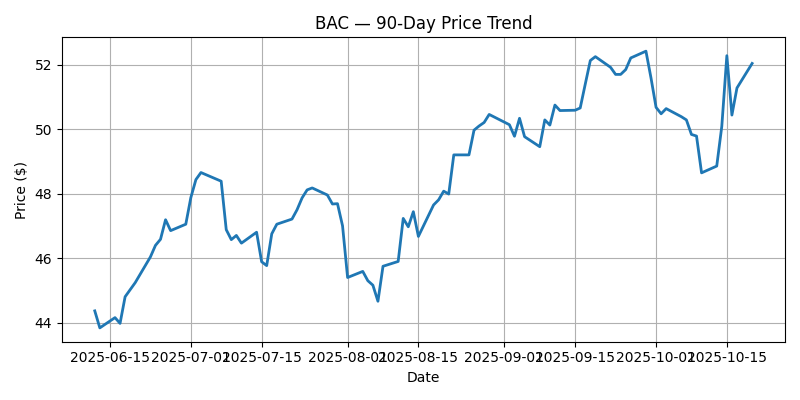</p>
<p align="center"><em>Figure: BAC Price Trend (Last 90 Days)</em></p>

---


*Prepared automatically by the AlphaLens Agents 🧠 — integrating SEC filings, transcripts, and market data.*


In [ ]:

# ============================================================
# 7. RUN EXAMPLE
# ============================================================

results = run_earnings_pack_pipeline("BAC")

from IPython.display import Markdown
with open(results, "r", encoding="utf-8") as f:
    display(Markdown(f.read()))